In [1]:
# Load paths for using psana
%env SIT_ROOT=/sdf/group/lcls/ds/ana
%env SIT_DATA=/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.54-py3/data:/sdf/group/lcls/ds/ana/data/
%env SIT_PSDM_DATA=/sdf/data/lcls/ds

env: SIT_ROOT=/sdf/group/lcls/ds/ana
env: SIT_DATA=/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.54-py3/data:/sdf/group/lcls/ds/ana/data/
env: SIT_PSDM_DATA=/sdf/data/lcls/ds


In [2]:
# # Run the notebook as if it's in the PROJECT directory
# %bookmark PROJ_ROOT /reg/data/ana03/scratch/cwang31/pf
# %cd -b PROJ_ROOT

In [3]:
!pwd

/sdf/data/lcls/ds/prj/prjcwang31/results/proj.peaknet-10k


## Auto labeler

In [4]:
import ray

In [5]:
import matplotlib.pyplot       as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
import matplotlib.font_manager as font_manager
%matplotlib inline

In [6]:
import random
import numpy as np

In [7]:
from bragg_peak_fitter.utils import get_patch_list
from bragg_peak_fitter.engine import PeakFitter
from bragg_peak_fitter.modeling.pseudo_voigt2d import PseudoVoigt2D

In [8]:
def random_display_in_grid(patch_list, ncols = 5, nrows = 10):
    fig   = plt.figure(figsize = (ncols * 2, nrows * 2))
    gspec = fig.add_gridspec( nrows, ncols )
    ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

    num_samples = min(ncols * nrows, len(patch_list))
    random_patch_list = random.sample(patch_list, num_samples)

    for patch_idx, patch in enumerate(random_patch_list):
        ax = ax_list[patch_idx]
        
        vmin = np.mean(patch) - 0 * patch.std()
        vmax = np.mean(patch) + 4 * patch.std()
        im = ax.imshow(patch, vmin = vmin, vmax = vmax)

In [23]:
def display_fitting(patch, model_params, idx, redchi, threshold_level = 0.5):
    ncols = 4
    nrows = 1
    fig   = plt.figure(figsize = (ncols * 2, nrows * 2))
    gspec = fig.add_gridspec( nrows, ncols )
    ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

    # Input image
    ax = ax_list[0]  
    vmin = np.mean(patch) - 0 * patch.std()
    vmax = np.mean(patch) + 4 * patch.std()
    im = ax.imshow(patch, vmin = vmin, vmax = vmax)
    ax.set_title(f'Input Data: {idx}')

    # Modeled image
    model_profile = PseudoVoigt2D(model_params)
    H, W = patch.shape[-2:]
    y = np.arange(0, H)
    x = np.arange(0, W)
    Y, X = np.meshgrid(y, x, indexing = 'ij')
    model_val = model_profile(Y, X)

    ax = ax_list[1]
    ax.imshow(model_val, vmin = vmin, vmax = vmax)
    ax.set_title(f'Model ({redchi:.1f})')

    # Residual
    residual_val = model_val - patch
    residual_std = np.std(residual_val)
    ax = ax_list[2]
    ax.imshow(residual_val, vmin = vmin, vmax = vmax)
    ax.set_title(f'Residual ({residual_std:.2f})')

    # Threshold map (half max)
    model_profile.includes_bg = False
    Y, X = np.meshgrid(y, x, indexing = 'ij')
    model_no_bg_val = model_profile(Y, X)
    model_no_bg_val -= model_no_bg_val.min()
    model_no_bg_val_half_max = model_no_bg_val >= (model_no_bg_val.max() * threshold_level)
    ax = ax_list[3]
    ax.imshow(model_no_bg_val_half_max, vmin = 0, vmax = 1)
    ax.set_title(f'Generated Label')

In [26]:
def perform_fitting(patch, model_params, idx, threshold_level = 0.5):
    ncols = 4
    nrows = 1
    fig   = plt.figure(figsize = (ncols * 2, nrows * 2))
    gspec = fig.add_gridspec( nrows, ncols )
    ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

    # Input image
    ax = ax_list[0]  
    vmin = np.mean(patch) - 0 * patch.std()
    vmax = np.mean(patch) + 4 * patch.std()
    im = ax.imshow(patch, vmin = vmin, vmax = vmax)
    ax.set_title(f'Input Data: {idx}')

    # Modeled image
    model_profile = PseudoVoigt2D(model_params)
    H, W = patch.shape[-2:]
    y = np.arange(0, H)
    x = np.arange(0, W)
    Y, X = np.meshgrid(y, x, indexing = 'ij')
    model_val = model_profile(Y, X)

    ax = ax_list[1]
    ax.imshow(model_val, vmin = vmin, vmax = vmax)
    ax.set_title(f'Model')

    # Residual
    residual_val = model_val - patch
    residual_std = np.std(residual_val)
    ax = ax_list[2]
    ax.imshow(residual_val, vmin = vmin, vmax = vmax)
    ax.set_title(f'Residual ({residual_std:.2f})')

    # Threshold map (half max)
    model_profile.includes_bg = False
    Y, X = np.meshgrid(y, x, indexing = 'ij')
    model_no_bg_val = model_profile(Y, X)
    model_no_bg_val -= model_no_bg_val.min()
    model_no_bg_val_half_max = model_no_bg_val >= (model_no_bg_val.max() * threshold_level)
    ax = ax_list[3]
    ax.imshow(model_no_bg_val_half_max, vmin = 0, vmax = 1)
    ax.set_title(f'Generated Label')

    return model_val, residual_val, model_no_bg_val, model_no_bg_val_half_max

In [11]:
# Read sample images and peaks...
img   = np.load("auto_labeler.data.img.npy")
peaks = np.load("auto_labeler.data.peaks.npy")


In [12]:
peaks_y = peaks[:, 0]
peaks_x = peaks[:, 1]
win_size = 4
uses_padding = True
patch_list = get_patch_list(peaks_y, peaks_x, img, win_size, uses_padding)

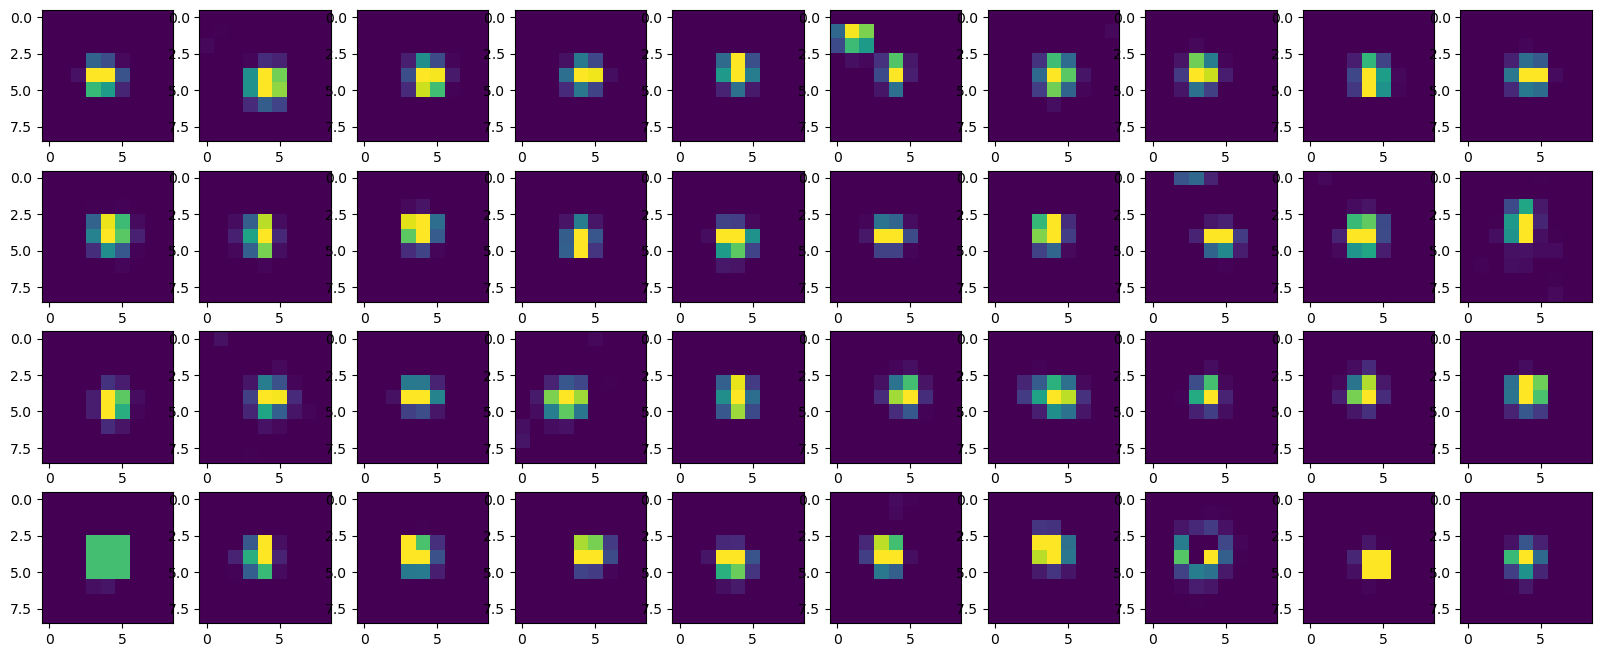

In [13]:
random_display_in_grid(patch_list, ncols = 10, nrows = 4)

In [14]:
peak_fitter = PeakFitter(num_cpus = 15)

In [15]:
patch_list[0].shape

(9, 9)

In [16]:
results = peak_fitter.fit_all_images(patch_list)

2024-02-15 22:59:17,882	INFO worker.py:1724 -- Started a local Ray instance.


/tmp/ipykernel_391017/858545833.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig   = plt.figure(figsize = (ncols * 2, nrows * 2))


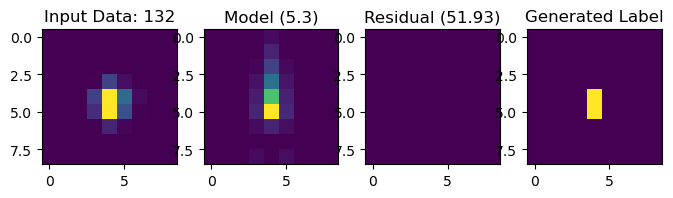

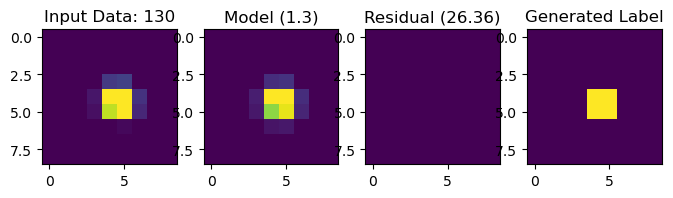

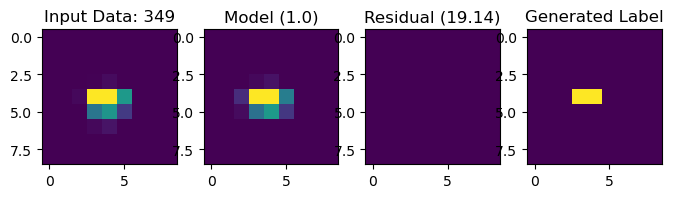

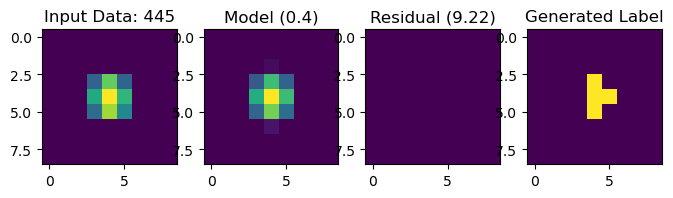

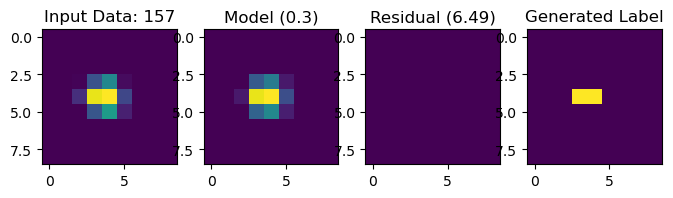

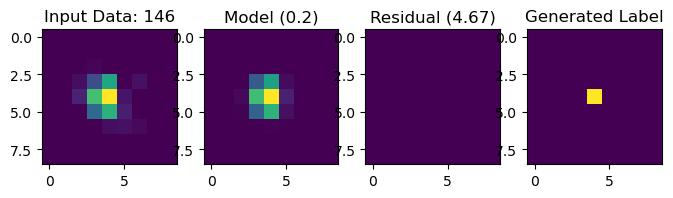

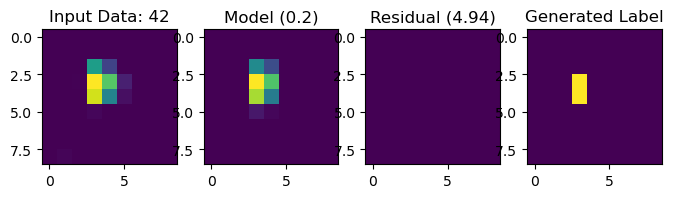

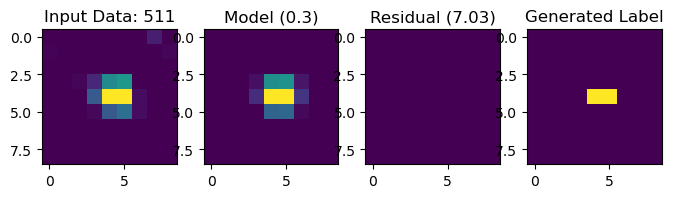

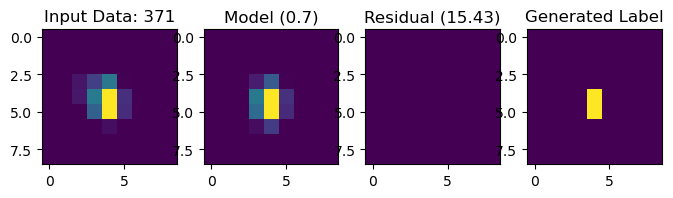

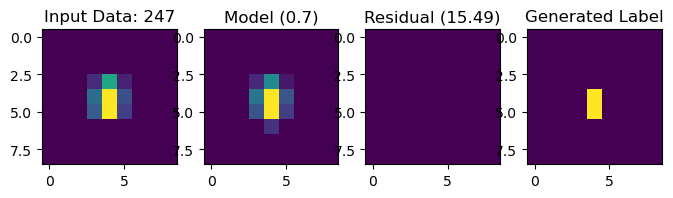

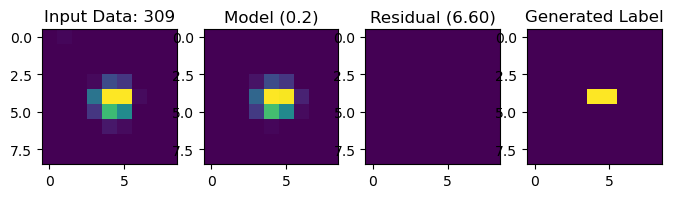

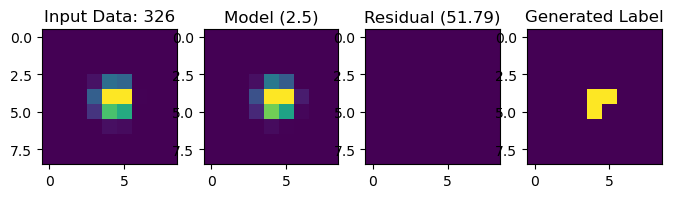

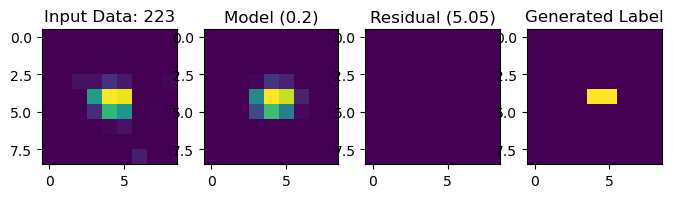

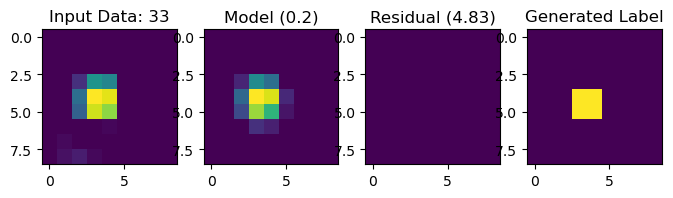

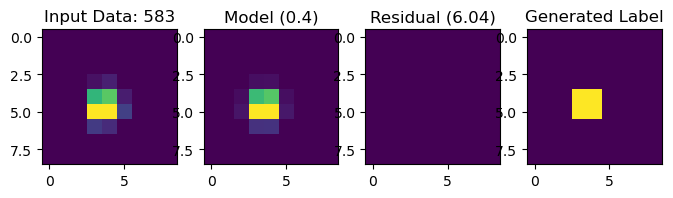

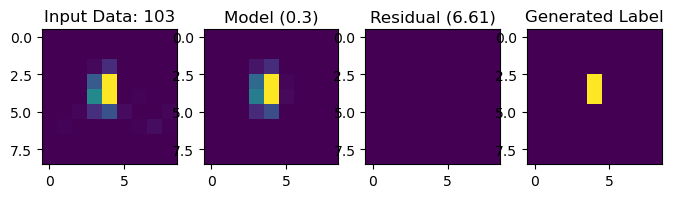

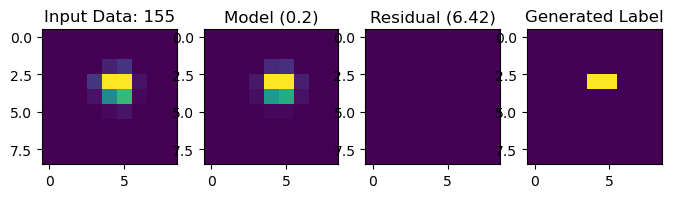

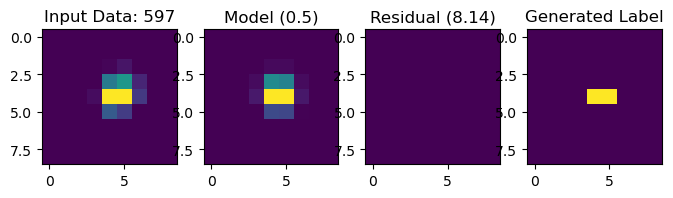

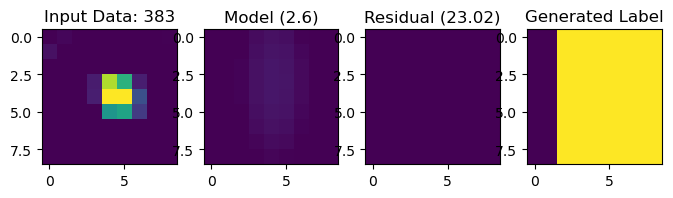

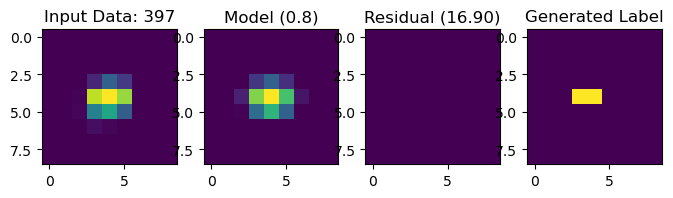

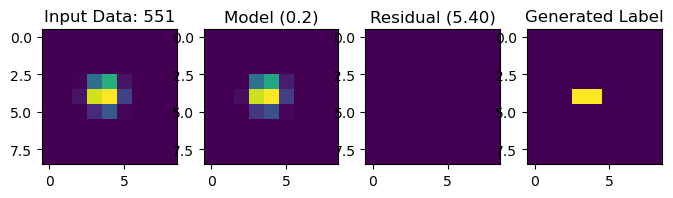

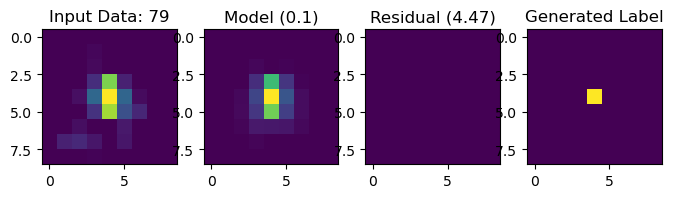

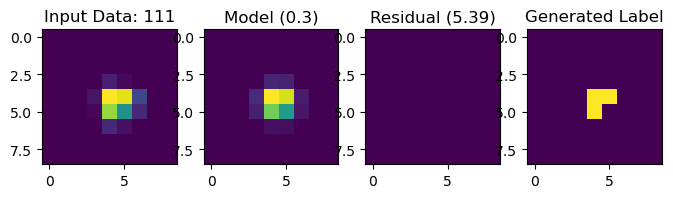

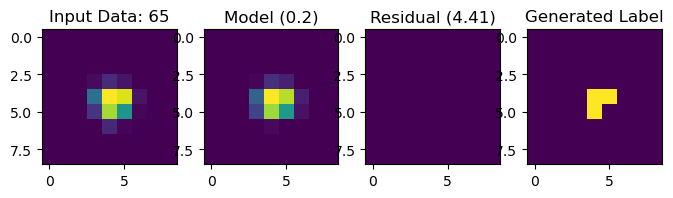

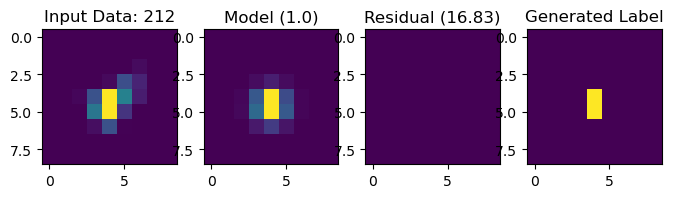

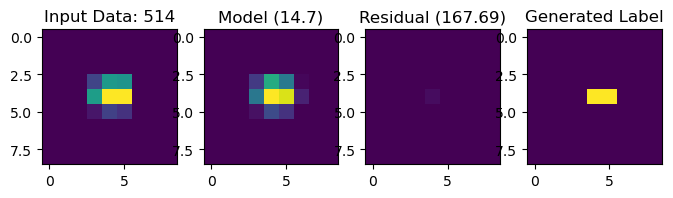

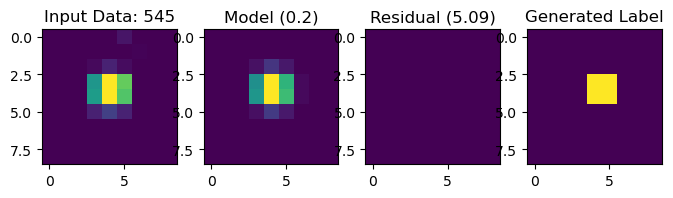

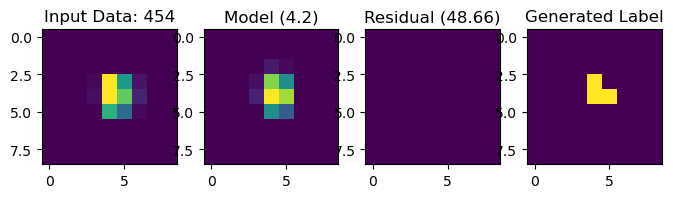

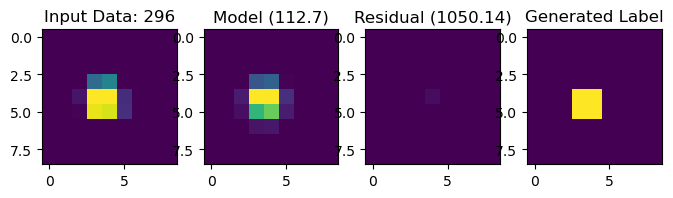

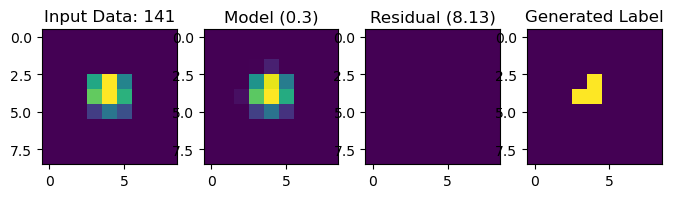

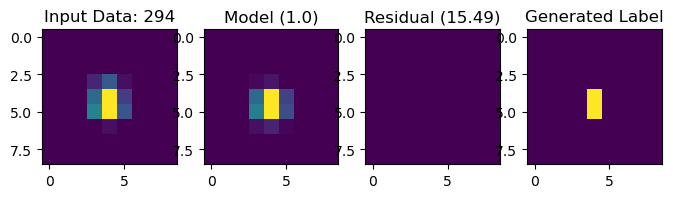

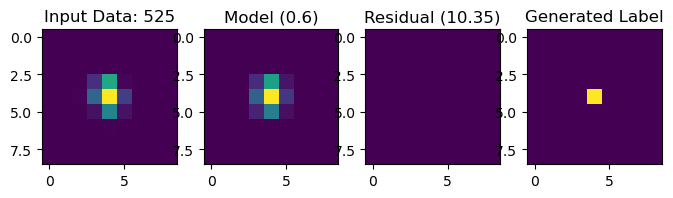

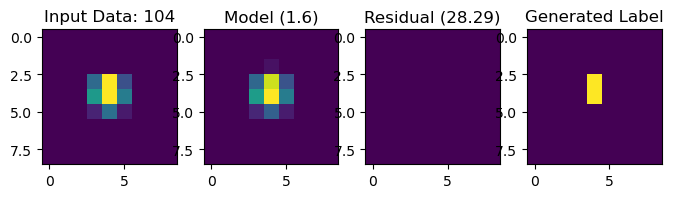

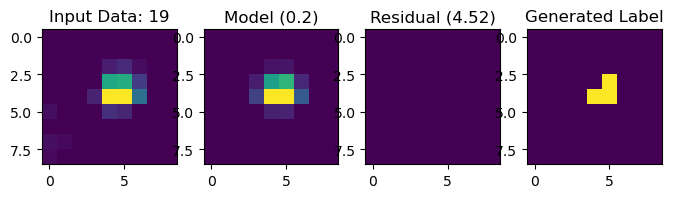

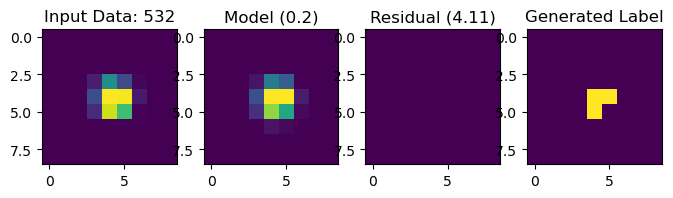

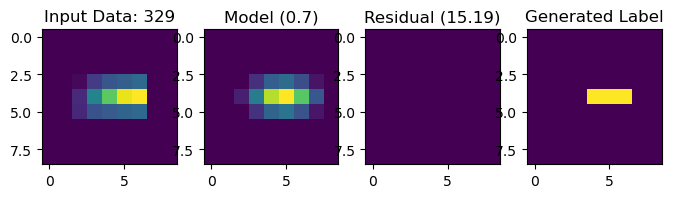

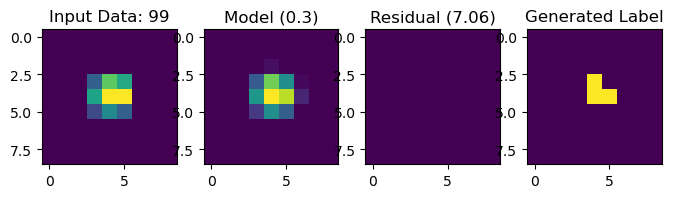

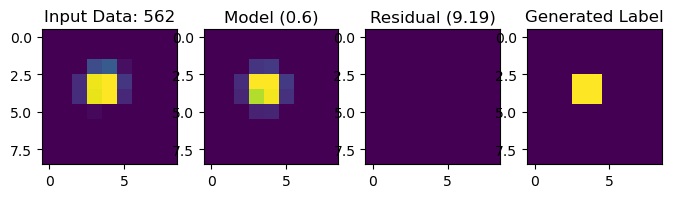

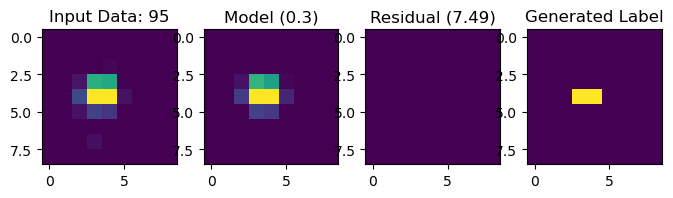

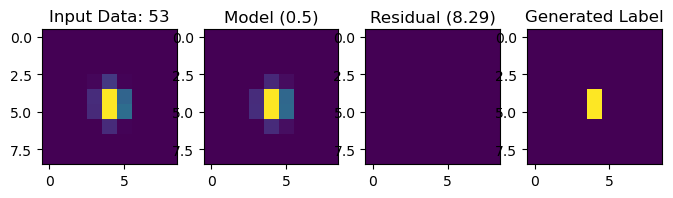

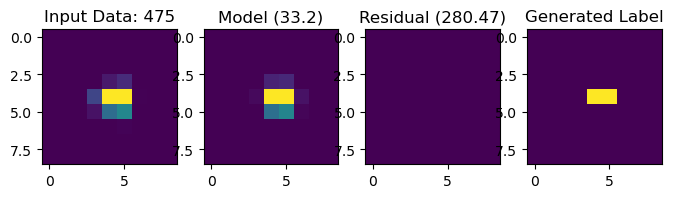

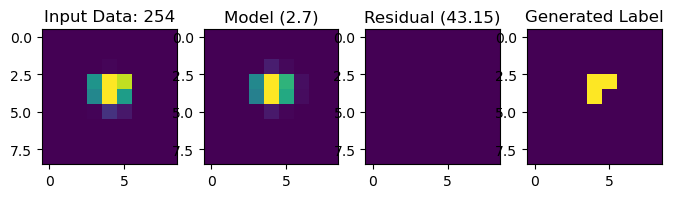

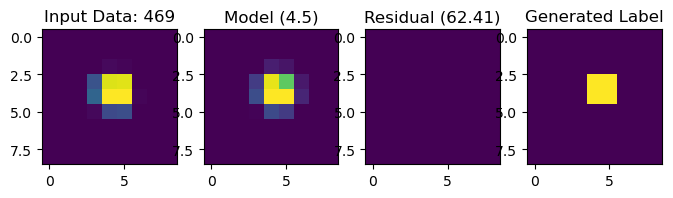

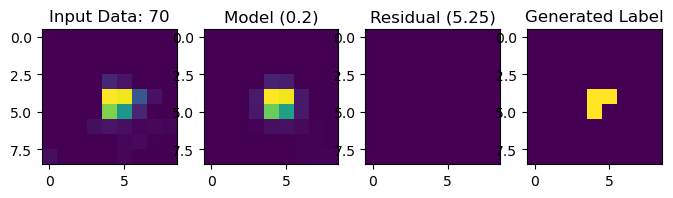

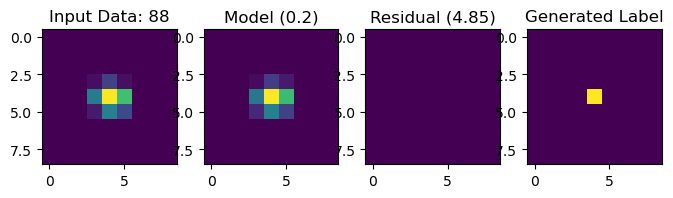

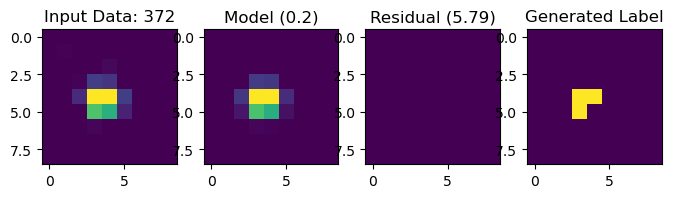

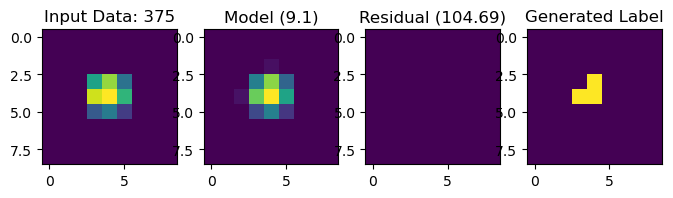

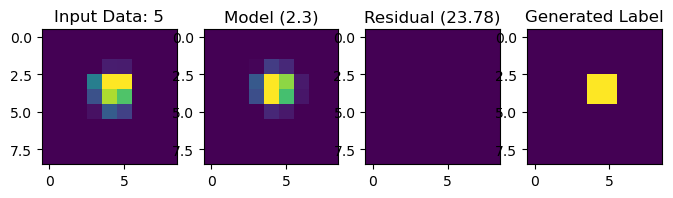

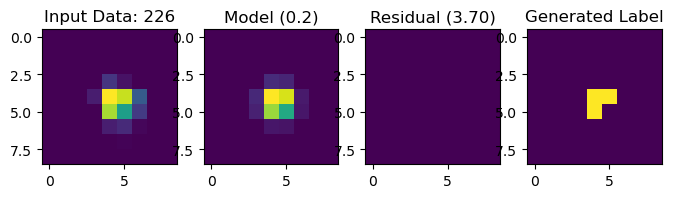

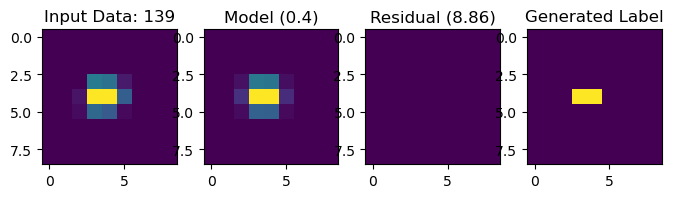

In [37]:
num_sample = 50
threshold_level = 1/2
random_sampled_idx_list = random.sample(range(len(patch_list)), k = num_sample)
for idx in random_sampled_idx_list:
    patch = patch_list[idx]
    fitting_result = results[idx]

    display_fitting(patch, fitting_result.params, idx, fitting_result.redchi, threshold_level = threshold_level)

In [22]:
random_sampled_idx_list

[141, 495, 217, 464, 61, 296, 409, 34, 542, 359]

## Diagnostics

Interesting patches: 70, 285, 217

### 217

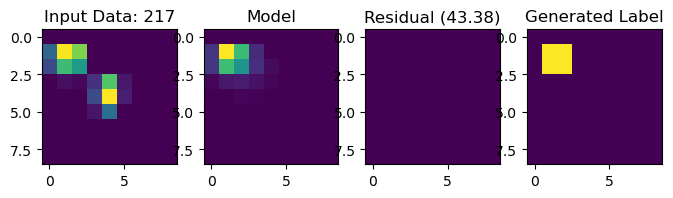

In [27]:
idx = 217
model_val, residual_val, model_no_bg_val, model_no_bg_val_half_max = perform_fitting(patch_list[idx], results[idx].params, idx, threshold_level = threshold_level)

In [28]:
results[idx]

### 213

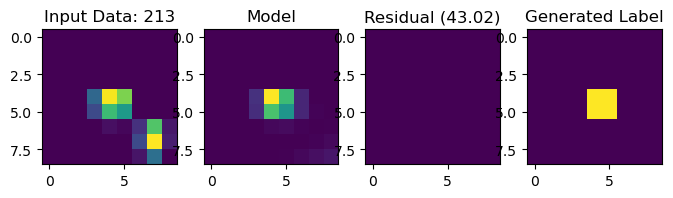

In [35]:
idx = 213
model_val, residual_val, model_no_bg_val, model_no_bg_val_half_max = perform_fitting(patch_list[idx], results[idx].params, idx, threshold_level = threshold_level)

In [36]:
results[idx]

### 383

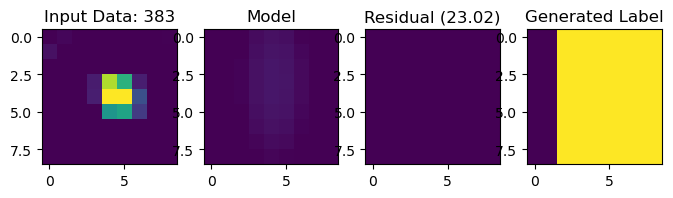

In [32]:
idx = 383
model_val, residual_val, model_no_bg_val, model_no_bg_val_half_max = perform_fitting(patch_list[idx], results[idx].params, idx, threshold_level = threshold_level)

In [33]:
results[idx]